In [9]:
import pandas as pd
import numpy as np
from pandas_datareader import DataReader as pdr
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
import pymssql
from csv import DictWriter
from datetime import datetime

from sklearn.linear_model import Ridge
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import itertools
import warnings
warnings.filterwarnings('ignore')

### Backtest - Linear Regression from class

In [10]:
#reads return from linear regression from first back test from class
rets_org = pd.read_csv("./rets_orig.csv", parse_dates=["date"], index_col="date")
rets_org.index = rets_org.index.to_period("M")

#### Fama-French factors

In [11]:
ff = pdr("F-F_Research_Data_5_Factors_2x3", "famafrench", start=2005)[0]/100

#### Market and 130/30 returns

In [12]:
rets_org["mkt"] = ff["Mkt-RF"] + ff["RF"]
rets_org["rf"] = ff["RF"]
rets_org["ls"] = 1.3*rets_org["best"] - 0.3*rets_org["worst"]

In [13]:
#initializes result table
row = {}
criteria = ["best", "worst", "mkt", "ls"]
row["features"] = ["Linear_reg - roeq, bm, mom12m"]
xrets_org = rets_org[["best", "worst", "mkt", "ls"]].subtract(rets_org.rf, axis=0)

for col in criteria:
    row["ret_" + col] = [12*rets_org[col].mean()]
    
for col in criteria:
    row["std_" + col] = [np.sqrt(12)*rets_org[col].std()]

for col in criteria:
    row["sratio_" + col] = [np.sqrt(12)*xrets_org[col].mean()/xrets_org[col].std()]

row["num_feat"] = 3
    
result = pd.DataFrame(row)

### Ridge Regression - (Alpha = 0.1)

In [14]:
model = Ridge(alpha=0.1)
prepoc = PolynomialFeatures(degree=2) #preprocessing, add a polynomial term of degree two to capture non-linearity
#prepoc = StandardScaler()
qt = QuantileTransformer(output_distribution="normal") #transform data to treat outliers

In [15]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
dfbase = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + dfbase
conn = create_engine(string).connect()

In [16]:
df = pd.read_sql(
    """
    select ticker, date, ret, mve, acc, agr, beta, bm, ep, gma, idiovol, lev, mom12m, mom1m, 
        operprof, roeq, roic, roaq, retvol, saleinv, currat
    from data
    where date>='2000-01'
    order by date, ticker
    """, 
    conn
)
df = df.dropna()
conn.close()

df = df.set_index(["date", "ticker"])

In [17]:
#drop largest stocks
df["size_rnk"] = df.groupby('date').mve.rank(ascending=False)
df = df[df["size_rnk"]>500] 
df.head(10)

ret        mve       acc       agr      beta        bm  \
date    ticker                                                                
2000-01 AAC     0.056338  12.072728 -0.144323 -0.139600  2.268646  1.893766   
        AACE   -0.067568  12.134491 -0.063165  0.078717  0.863053  0.339860   
        AAGP    0.364865   8.659571 -0.065554 -0.049251  3.448574  0.272639   
        AAII    0.109589  11.963973  0.040705  0.087686  1.777969  0.256150   
        AAIR    0.048276  12.603822 -0.085808 -0.132433  1.603224  0.326549   
        AAM     0.083333  10.055382  0.238524  0.252592  2.635396  1.311158   
        AAON    0.108696  11.407266 -0.012415  0.180902  0.751212  0.421501   
        AAS     0.193416  13.509400 -0.045706 -0.110461  1.048264  0.054139   
        AASP   -0.060241   8.266325  0.058921  0.526711  0.437517  0.561185   
        AATT    0.022901  12.371572 -0.174320  0.165060  2.292406  0.457054   

                      ep       gma   idiovol        lev    mom12m     mom1m  \
date    ticker                                                                
2000-01 AAC    -0.586435 -0.027672  0.084462   3.232779  0.241379 -0.013889   
        AACE    0.058082  0.201136  0.051541   0.682613  0.095833  0.125475   
        AAGP   -0.011439  0.814228  0.241297   0.040725 -0.646154 -0.195652   
        AAII    0.020018  0.451732  0.116112   0.127485 -0.510791  0.073529   
        AAIR   -0.239133  0.290907  0.104955   1.882961  0.761905 -0.020270   
        AAM    -6.091087 -0.220700  0.155609  13.180766 -0.666667 -0.294118   
        AAON    0.090306  0.530220  0.052385   0.450578  0.355705  0.138614   
        AAS     0.036317  0.240802  0.067126   1.061775 -0.619231  0.227273   
        AASP   -0.494222  0.034160  0.155298   5.795259 -0.388889  0.886364   
        AATT    0.052021  0.726804  0.088989   0.369821  0.370370  0.062162   

                 operprof      roeq      roic      roaq    retvol    saleinv  \
date    ticker                                                                 
2000-01 AAC     -0.215772  0.053986 -0.061952  0.017297  0.013900   8.178278   
        AACE     0.580319  0.049065  0.211095  0.015624  0.020628  80.949040   
        AAGP     0.876987  0.038481 -0.003277  0.032100  0.029503   4.959366   
        AAII     0.686724 -0.041963  0.078168 -0.025050  0.048943   5.162492   
        AAIR     1.032463  0.254678  0.008910  0.036292  0.035308  38.247170   
        AAM     -0.736722 -0.103489 -0.342144 -0.018583  0.055908  -0.028851   
        AAON     1.147671  0.092324  0.175195  0.047632  0.016566   8.781332   
        AAS     26.419188  0.175641  0.103378  0.012655  0.036034   9.961589   
        AASP     0.028064 -0.111601 -0.149269 -0.033838  0.225360  15.840000   
        AATT     1.570663  0.041950  0.189149  0.024038  0.011895  13.680429   

                   currat  size_rnk  
date    ticker                       
2000-01 AAC     18.508028    1629.0  
        AACE     1.066674    1583.0  
        AAGP     6.820513    3373.0  
        AAII     1.804698    1687.0  
        AAIR     0.632617    1343.0  
        AAM     19.238907    2858.0  
        AAON     2.154328    2048.0  
        AAS      1.397119     868.0  
        AASP     1.138249    3440.0  
        AATT     1.811587    1460.0

In [18]:
#transform features each month
def qt_df(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

In [19]:
#transform target each month
def qt_ser(s):
    x = s.copy()
    x = x.to_numpy().reshape(-1, 1)
    x = qt.fit_transform(x).flatten()
    return pd.Series(x, index=s.index)

In [20]:
#train and predict

def train_predict(df1, features, ridge_pipe):
    predictions = None
    dates = ["2005-01", "2010-01", "2015-01", "2020-01", "3000-01"]
    for train_date, end_date in zip(dates[:-1], dates[1:]):

        filter1 = df1.index.get_level_values("date") < train_date
        filter2 = df1.index.get_level_values("date") < end_date

        train = df1[filter1]
        test = df1[~filter1 & filter2]

        Xtrain = train[features]
        ytrain = train["target"]
        Xtest = test[features]
        ytest = test["target"]

        ridge_pipe.fit(Xtrain, ytrain)
        pred = ridge_pipe.predict(Xtest)
        pred = pd.Series(pred, index=test.index)
        predictions = pd.concat((predictions, pred))
    
    df1["predict"] = predictions
    
    return df1

In [21]:
#ranks the stocks
def ranking(df2, numstocks):

    df2 = df2.dropna(subset=["predict"])

    df2["rnk"] = df2.groupby("date").predict.rank(method="first", ascending=False)
    best = df2[df2.rnk<=numstocks]

    df2["rnk"] = df2.groupby("date").predict.rank(method="first")
    worst = df2[df2.rnk<=numstocks]

    best_rets = best.groupby("date").ret.mean()
    worst_rets = worst.groupby("date").ret.mean()
    rets = pd.concat((best_rets, worst_rets), axis=1)
    rets.columns = ["best", "worst"]

    return rets

In [22]:
def rets_cal(ff, rets):

    rets["mkt"] = ff["Mkt-RF"] + ff["RF"]
    rets["rf"] = ff["RF"]
    rets["ls"] = 1.3*rets["best"] - 0.3*rets["worst"]
    
    return rets

In [23]:
def eval1(rets, features, result, num):
    f_row = "Ridge Regression - "
    for feat in features:
        f_row += (feat + ", ")

    criteria = ["best", "worst", "mkt", "ls"]
    row = {}
    row["features"] = [f_row]
    xrets = rets[["best", "worst", "mkt", "ls"]].subtract(rets.rf, axis=0)
    
    for col in criteria:
        row["ret_"+col] = [12*rets[col].mean()]
    
    for col in criteria:
        row["std_"+col] = [np.sqrt(12)*rets[col].std()]
        
    for col in criteria:
        row["sratio_"+col] = [np.sqrt(12)*xrets[col].mean()/xrets[col].std()]    
        
    row["num_feat"] = [num]
    
    #with open('Ridge_result.csv', 'a') as f_object:
        #dictwriter_object = DictWriter(f_object, fieldnames=list(row.keys()))
        #dictwriter_object.writerow(row)
        #f_object.close()
    
    temp_df = pd.DataFrame(row)
    result = pd.concat([result, temp_df])
    
    return result, xrets

In [24]:
features = ["acc", "agr", "beta", "bm", "ep", "gma", "lev", 
            "mom12m", "mom1m", "operprof", "roic", "roaq", 
            "retvol", "saleinv", "currat"]
numst = [50, 75, 100, 125, 150, 175, 200]

In [25]:
for numstocks in numst:
    print(1)
    ridge_pipe = None

    ridge_pipe = make_pipeline(prepoc, model) #create pipeline using SVR

    df_copy = df.copy()
    df_copy[features] = df_copy.groupby("date", group_keys=False)[features].apply(qt_df)
    df_copy["target"] = df_copy.groupby("date", group_keys=False).ret.apply(qt_ser)
    df_copy = train_predict(df_copy, features, ridge_pipe)
    rets = ranking(df_copy, numstocks)
    rets.index = pd.to_datetime(rets.index)
    rets.index = rets.index.to_period("M")
    rets = rets_cal(ff, rets)
    result, xrets = eval1(rets, features, result, len(features))
    

1
1
1
1
1
1
1


In [43]:
result

,features,ret_best,ret_worst,ret_mkt,ret_ls,std_best,std_worst,std_mkt,std_ls,sratio_best,sratio_worst,sratio_mkt,sratio_ls,num_feat
0,"Linear_reg - roeq, bm, mom12m",0.148635,0.115483,0.109803,0.158581,0.184892,0.369055,0.150797,0.175752,0.740514,0.281762,0.651299,0.836286,3
0,"Ridge Regression - acc, agr, beta, bm, ep, gma...",0.200693,-0.099567,0.109803,0.290771,0.209380,0.407258,0.150797,0.211297,0.901837,-0.272005,0.651299,1.319079,15
0,"Ridge Regression - acc, agr, beta, bm, ep, gma...",0.212129,-0.088310,0.109803,0.302261,0.200125,0.379296,0.150797,0.194927,1.000662,-0.262414,0.651299,1.488502,15
0,"Ridge Regression - acc, agr, beta, bm, ep, gma...",0.206174,-0.078828,0.109803,0.291675,0.196827,0.359977,0.150797,0.188443,0.987219,-0.250183,0.651299,1.483374,15
0,"Ridge Regression - acc, agr, beta, bm, ep, gma...",0.193907,-0.053828,0.109803,0.268228,0.195430,0.355892,0.150797,0.184683,0.931584,-0.182839,0.651299,1.386927,15
0,"Ridge Regression - acc, agr, beta, bm, ep, gma...",0.190541,-0.034534,0.109803,0.258064,0.193443,0.347263,0.150797,0.181852,0.923880,-0.131875,0.651299,1.352965,15
0,"Ridge Regression - acc, agr, beta, bm, ep, gma...",0.185200,-0.012774,0.109803,0.244592,0.191162,0.339032,0.150797,0.178380,0.906934,-0.070966,0.651299,1.303779,15
0,"Ridge Regression - acc, agr, beta, bm, ep, gma...",0.180127,-0.004622,0.109803,0.235552,0.189386,0.330404,0.150797,0.176176,0.888849,-0.048169,0.651299,1.269300,15


### Raw Returns - Accumulations

Text(0.5, 1.0, 'Linear Regression from class')

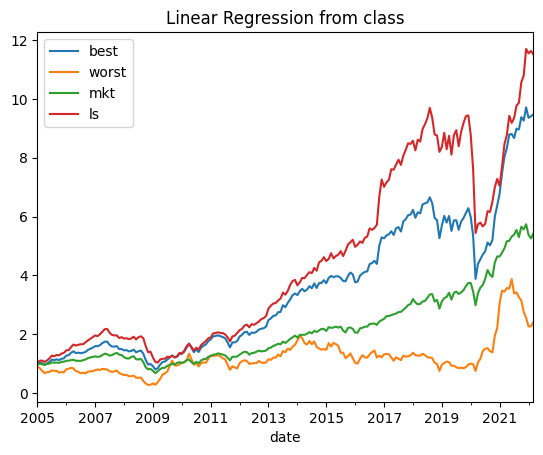

In [26]:
#original first backtest from class
(1+rets_org[["best", "worst", "mkt", "ls"]]).cumprod().plot()
plt.title("Linear Regression from class")

Text(0.5, 1.0, 'Ridge Regression')

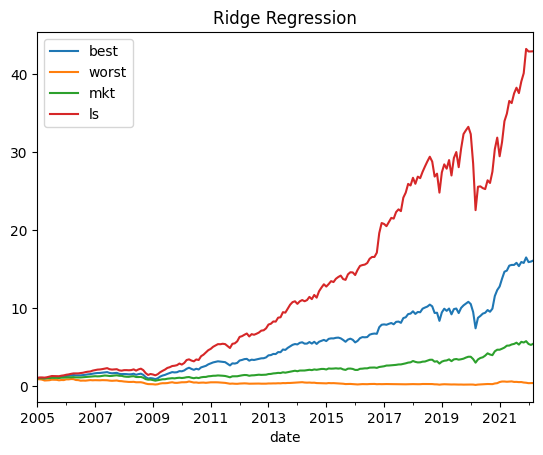

In [27]:
#Ridge backtest
(1+rets[["best", "worst", "mkt", "ls"]]).cumprod().plot()
plt.title("Ridge Regression")

#### Ridge Regression - Mean

In [28]:
print(12*rets[["best", "worst", "mkt", "ls"]].mean())

best     0.180127
worst   -0.004622
mkt      0.109803
ls       0.235552
dtype: float64


#### Ridge Regression - Risk

In [29]:
print(np.sqrt(12)*rets[["best", "worst", "mkt", "ls"]].std())

best     0.189386
worst    0.330404
mkt      0.150797
ls       0.176176
dtype: float64


#### Ridge Regression - Sharpe Ratio

In [30]:
np.sqrt(12)*xrets[["best", "worst", "mkt", "ls"]].mean()/xrets[["best", "worst", "mkt", "ls"]].std()

best     0.888849
worst   -0.048169
mkt      0.651299
ls       1.269300
dtype: float64

### 130/30 drawdowns

Text(0, 0.5, 'Drawdown')

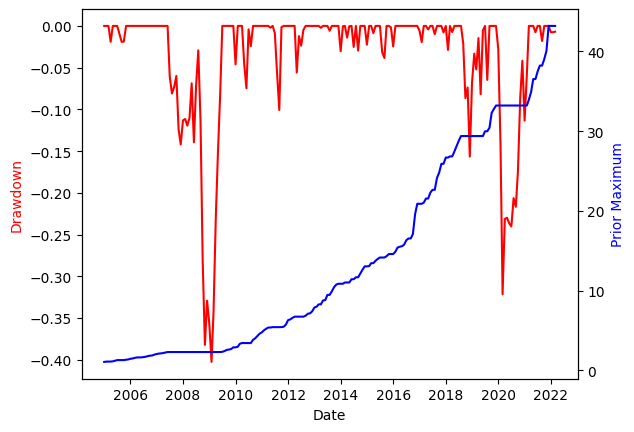

In [31]:
ls = (1+rets.ls).cumprod()
lsmax = ls.expanding().max()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.plot(rets.index.to_timestamp(), lsmax, 'b-')
ax1.plot(rets.index.to_timestamp(), ls/lsmax - 1, 'r-')

ax1.set_xlabel('Date')
ax2.set_ylabel('Prior Maximum', color='b')
ax1.set_ylabel('Drawdown', color='r')

In [32]:
tables = []
coefs = []
actives = []

for string in ["best~mkt", "worst~mkt", "ls~mkt"]:
    result2 = smf.ols(string, data=xrets).fit()
    tables.append(result2.summary().tables[1])
    coefs.append(result2.params)
    actives.append(result2.params["Intercept"] + result2.resid)

In [33]:
for table in tables:
    print(table)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0051      0.002      2.665      0.008       0.001       0.009
mkt            1.0939      0.043     25.379      0.000       1.009       1.179
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0146      0.005     -3.188      0.002      -0.024      -0.006
mkt            1.6142      0.103     15.647      0.000       1.411       1.818
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0110      0.002      5.096      0.000       0.007       0.015
mkt            0.9378      0.049     19.272      0.000       0.842       1.034


In [34]:
actives = [pd.Series(x, index=xrets.index) for x in actives]
actives = pd.concat(actives, axis=1)
actives.columns = ["best", "worst", "ls"]
np.sqrt(12) * actives.std()

best     0.093320
worst    0.223368
ls       0.105355
dtype: float64

In [35]:
info_ratios = np.sqrt(12)*actives.mean()/actives.std()
info_ratios

best     0.654500
worst   -0.783093
ls       1.251736
dtype: float64

### 130/30 breakdown into market and active returns

Text(0.5, 1.0, 'Ridge Regression')

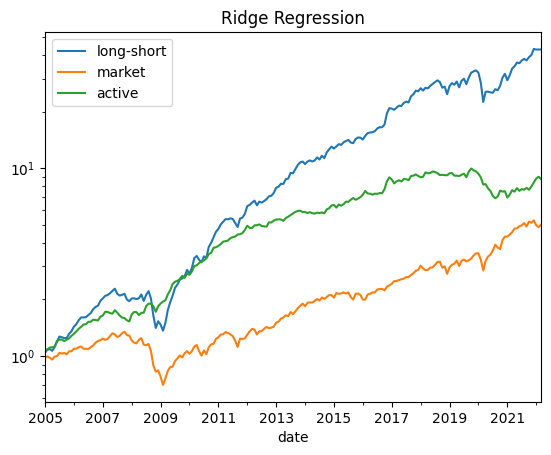

In [36]:
logy = True

beta = coefs[-1]["mkt"]

(1+rets.ls).cumprod().plot(label="long-short", logy=logy)
(1+ rets.rf + beta*xrets.mkt).cumprod().plot(label="market", logy=logy)
(1+actives.ls).cumprod().plot(label="active", logy=logy)
plt.legend()
plt.title("Ridge Regression")

In [37]:
xrets[["smb", "hml", "rmw", "cma"]] = ff[["SMB", "HML", "RMW", "CMA"]]

### Fama-French Benchmark

In [38]:
tables = []
coefs = []
actives = []

strings = [x+"~mkt+smb+hml+rmw+cma" for x in ["best", "worst", "ls"]]
for string in strings:
    result3 = smf.ols(string, data=xrets).fit()
    tables.append(result3.summary().tables[1])
    coefs.append(result3.params)
    actives.append(result3.params["Intercept"] + result3.resid)

In [39]:
for table in tables:
    print(table)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0066      0.001      5.097      0.000       0.004       0.009
mkt            0.8886      0.032     27.571      0.000       0.825       0.952
smb            0.7046      0.057     12.259      0.000       0.591       0.818
hml            0.3125      0.051      6.094      0.000       0.211       0.414
rmw            0.0924      0.076      1.223      0.223      -0.057       0.241
cma           -0.0608      0.092     -0.662      0.509      -0.242       0.120
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0094      0.004     -2.508      0.013      -0.017      -0.002
mkt            1.2319      0.092     13.341      0.000       1.050       1.414
smb            1.3700      0.165      8.320      0.0

In [40]:
actives = [pd.Series(x, index=xrets.index) for x in actives]
actives = pd.concat(actives, axis=1)
actives.columns = ["best", "worst", "ls"]
np.sqrt(12) * actives.std()

best     0.060879
worst    0.174421
ls       0.083889
dtype: float64

In [41]:
info_ratios = np.sqrt(12)*actives.mean()/actives.std()
info_ratios

best     1.308090
worst   -0.643595
ls       1.635527
dtype: float64

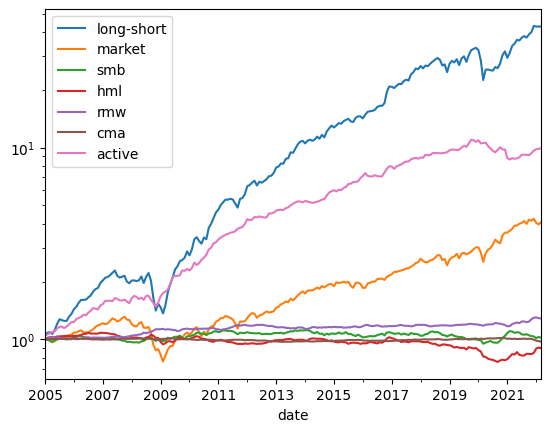

In [42]:
logy = True

betas = coefs[-1]

(1+rets.ls).cumprod().plot(label="long-short", logy=logy)
(1 + rets.rf + betas["mkt"]*xrets.mkt).cumprod().plot(label="market", logy=logy)
(1 + betas["smb"]*xrets.smb).cumprod().plot(label="smb", logy=logy)
(1 + betas["hml"]*xrets.hml).cumprod().plot(label="hml", logy=logy)
(1 + betas["rmw"]*xrets.rmw).cumprod().plot(label="rmw", logy=logy)
(1 + betas["cma"]*xrets.cma).cumprod().plot(label="cma", logy=logy)
(1+actives.ls).cumprod().plot(label="active", logy=logy)
plt.legend()